In [4]:
import os, shutil, glob, pywt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt, hilbert, spectrogram
from scipy.io.wavfile import read

In [5]:
# Sort training sets into abnormal and normal sets

def empty_dir(dir_path):
    """
    If dir_path exists, remove all contents in dir_path
    Otherwise, create new directory with dir_path
    
    Input:
            dir_path   :   path to directory to empty
    """
    
    if os.path.exists(dir_path):
        # remove directory
        shutil.rmtree(dir_path)
        
    if not os.path.exists(dir_path):
        # create directory
        os.makedirs(dir_path)
        
        
def sort_files(src_dir='./', normal_dir='./normal', \
               abnormal_dir='./abnormal'):
    """
    Sort all wav files from folders training-? in src_dir 
    based on it's header file
        
    Copy them into normal_dir and abnormal_dir
    
    normal_dir and abnormal_dir may not exist, otherwise, 
    all their contents will be deleted
    
    Inputs:
            src_dir        :   path to source, must include
                               subfolders traing-[a-f]
            normal_dir     :   directory to save normal files
            abnormal_dir   :   directory to save abnormal files
    """
    
    # prepare normal_dir, abnormal_dir
    empty_dir(normal_dir)
    empty_dir(abnormal_dir)
    
    # sort and copy
    for header in glob.glob(src_dir+'training-?/*.hea'):
        # Read the last line
        f = open(header, 'r')
        last_line = f.readlines()[-1]
        
        # sort files
        wave = os.path.splitext(header)[0]+'.wav'
        if "Normal" in last_line:
            shutil.copy2(wave, normal_dir)
        elif "Abnormal" in last_line:
            shutil.copy2(wave, abnormal_dir)

            
# test            
sort_files()

Processing ./abnormal/a0001.wav...


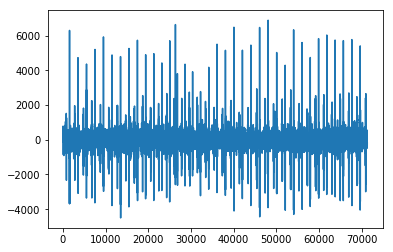

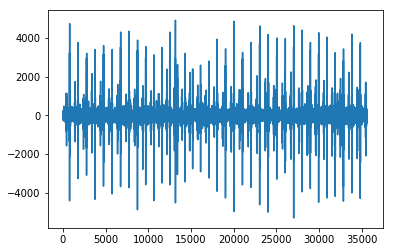

Processing ./abnormal/a0002.wav...


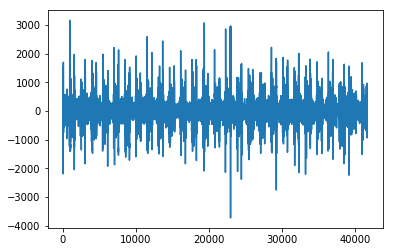

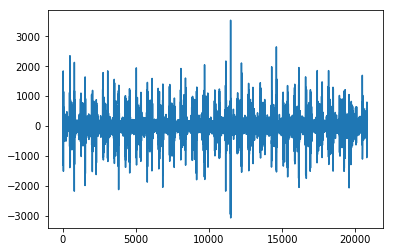

Processing ./abnormal/a0003.wav...


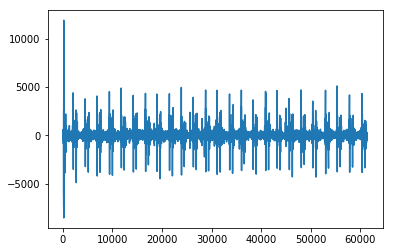

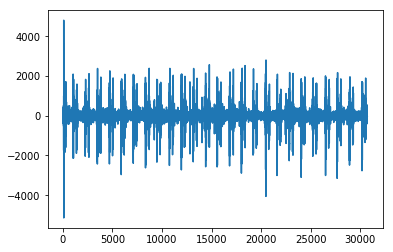

Processing ./abnormal/a0004.wav...


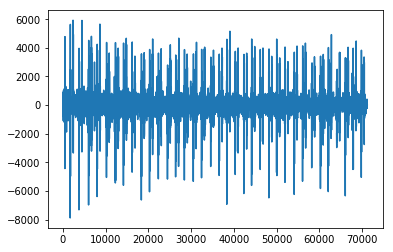

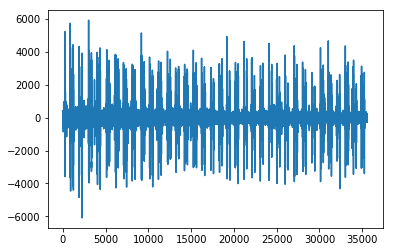

Processing ./abnormal/a0005.wav...


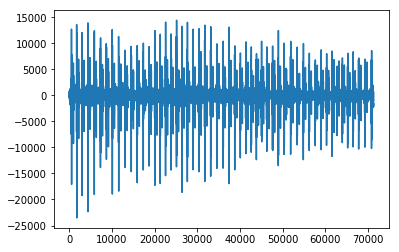

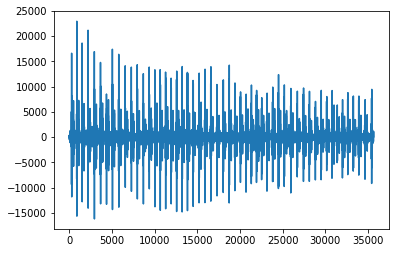

Processing ./abnormal/a0006.wav...


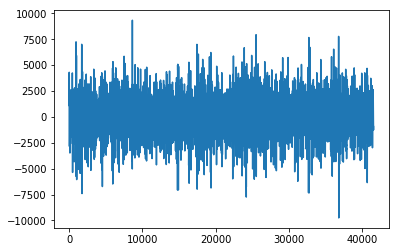

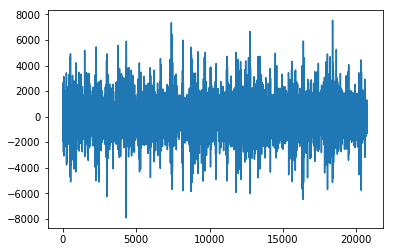

Processing ./abnormal/a0008.wav...


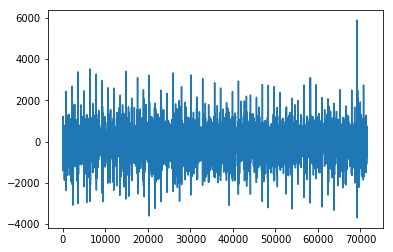

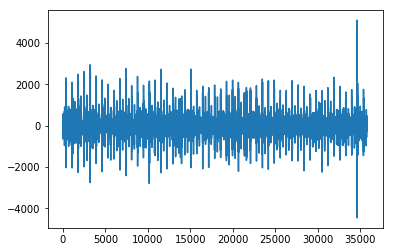

Processing ./abnormal/a0010.wav...


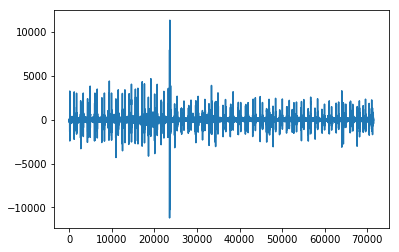

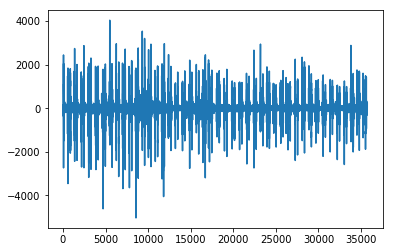

Processing ./abnormal/a0013.wav...


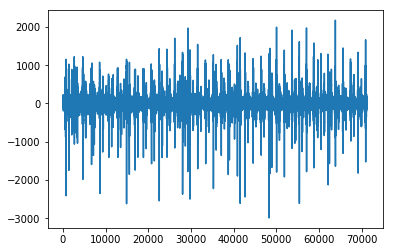

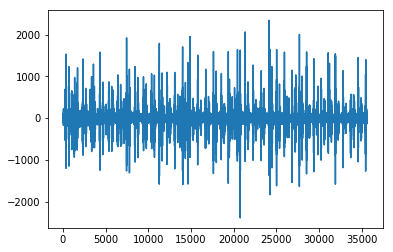

Processing ./abnormal/a0014.wav...


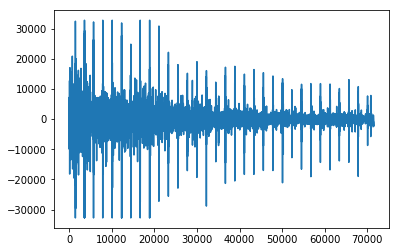

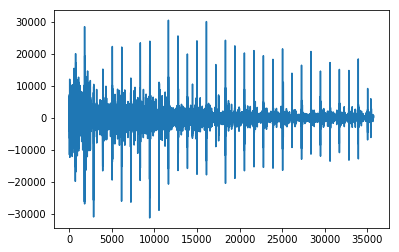

Processing ./abnormal/a0015.wav...


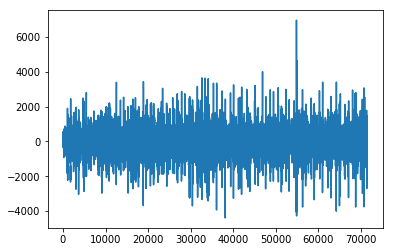

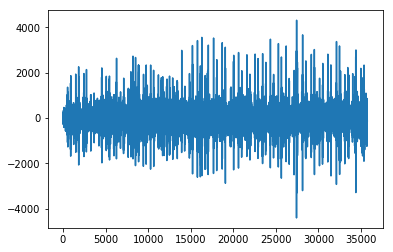

In [5]:
# Preprocessing functions

def resample(data, cur_fs, new_fs=1000):
    """
    Resample data from cur_fs to new_fs based on
        https://github.com/MIT-LCP/wfdb-python/blob/master/wfdb/processing/basic.py
    
    Inputs:
            data            :  numpy signal to resample
            cur_fs          :  current sample rate (Hz)
            new_fs          :  new sample rate (Hz)
    
    Outputs:
            new_fs          :  new sample rate
            resampled_data  :  resampled data
    """
    
    new_length = int(data.shape[0]*new_fs/cur_fs)
    resampled_data = signal.resample(data, num=new_length)
    return new_fs, resampled_data


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Bandpass filter based on 
        http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    
    Inputs:
            data       :  numpy signal to filter
            lowcut     :  lower bounde (Hz)
            highcut    :  upper bound (Hz)
            fs         :  sample rate (Hz)
            order      :  order of butterworth filter
    
    Output:
            y          :  filtered data
    """

    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y


def schmidt_remove_spikes(data, fs):
    """
    Removes spikes in data as done by Schmidt
    
    Inputs:
            data          :  numpy signal to remove spikes
            fs            :  sample rate (Hz)
            
    Output:
            despiked_data :  data without spikes
    """
    
    # Find window size
    windowsize = round(fs/2)

    # find any samples outside of integer number of windows
    trailingsamples = data.shape[0] % windowsize
    
    # find number of windows
    nwindow = data.shape[0] // windowsize
    
    # reshape data into number of windows
    sampleframes = np.reshape(data[:data.shape[0]-trailingsamples], \
                             (nwindow, windowsize))
    # find MAAs, its max
    MAAs = np.amax(np.abs(sampleframes), axis=1)
    max_MAA = max(MAAs)
    
    # while there are still samples > 3*median of MAAs
    while (max_MAA > 3*np.median(MAAs)):
        #print('Remove spike...')
        # find spike position
        i = np.where(MAAs == max_MAA)[0][0]
        j = np.where(np.abs(sampleframes[i]) == max_MAA)[0][0]
        # find zero crossings
        zero_crossings = np.where(np.diff(np.sign(sampleframes[i])))[0]
        # find start and end of spike
        start = 0
        end = windowsize
        for k in zero_crossings: 
            if (k < j):
                start = k
            elif (k > j):
                end = k
                break;
        # set to Zero
        sampleframes[i, start:end] = 0.0001
        # recaculate MAAs and max_MAA
        MAAs = np.amax(np.abs(sampleframes), axis=1)
        max_MAA = max(MAAs)
    
    # return despiked_data
    despiked_data = np.ravel(sampleframes)
    despiked_data = np.append(despiked_data, \
                              data[despiked_data.shape[0]:])
    return despiked_data


def pre_process(data, fs):
    """
    Resample to 1000Hz, bandpass filter 25-400Hz, remove spikes
    
    Inputs:
            data    :   numpy data to pre-process
            fs      :   sample rate of data
            
    Outputs:
            new_data    :  pre-processed data
            new_fs  :  new sample rate"""
    
    # get suitable length
    if (data.shape[0] > 60*fs):
        new_data = data[:60*fs]
        
    # resample to 1000Hz
    (new_fs, new_data) = resample(data, fs)
    
    # 25-400Hz 5th order Butterworth bandpass
    new_data = butter_bandpass_filter(new_data, 25, 400, new_fs)
    
    # remove spikes
    new_data = schmidt_remove_spikes(new_data, new_fs)
    return new_data, new_fs


def show(data):
    plt.plot(data)
    plt.show()

    
# test
k = 0
for file in glob.glob('./abnormal/*.wav'):
    print('Processing ' + file + '...')
    (rate, data) = read(file)
    show(data)
    (data, rate) = pre_process(data, rate)
    show(data)
    k=k+1
    if (k > 10):
        break

Processing ./abnormal/a0001.wav...


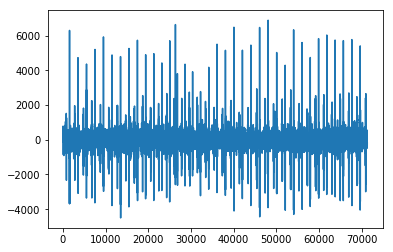

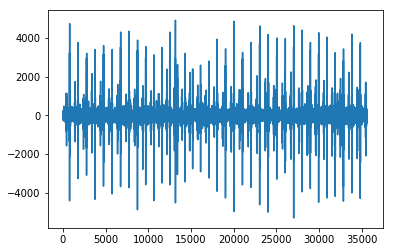

[array([-0.78313623, -0.8221391 , -0.78207624, ..., -0.14795971,
       -0.4685629 , -0.64003983]), array([-0.66395685, -0.63248791, -0.57903013, ..., -0.2619143 ,
       -0.43447841, -0.54213493]), array([-0.33697824, -0.28412198, -0.22957514, ..., -0.4851483 ,
       -0.43751448, -0.38811717]), array([ 0.43041092, -0.2681251 , -0.05093143,  1.67718638, -0.51357395,
       -0.52739626, -0.62395413, -0.39460944, -0.20631686,  0.37030244,
        0.56679192,  0.36211763,  0.06344192,  0.08438051, -0.85266544,
        0.92311807,  1.35266756,  1.34743078,  0.96765434,  1.67429401,
        1.99106452, -0.40874156, -0.06981932, -0.85101546,  0.02261379,
       -0.36295369, -0.24998749, -0.57036581, -0.70078853, -0.82668396,
       -0.3768116 , -0.60039403, -0.23516455, -0.65443656,  0.16431644,
       -0.50472385, -0.19158815, -0.89495703, -0.63644245,  0.32725787,
       -0.6775959 , -1.00360617, -0.25529542, -1.03187304,  2.57962396,
        0.22653613, -0.05018113, -0.84565736,  0.18625

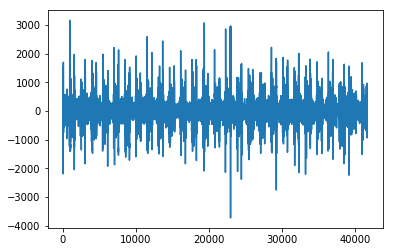

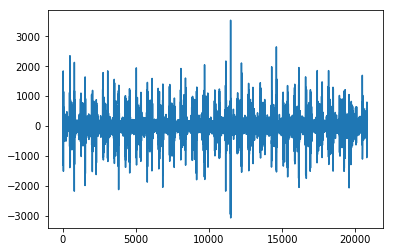

[array([ 1.16248678,  1.75860829,  2.57246381, ..., -0.17822127,
        0.48143594,  1.39640955]), array([ 0.74255358,  1.86460505,  2.99772331, ..., -0.56625649,
        0.55477113,  1.36966228]), array([-0.18902435, -0.18433825, -0.17839023, ..., -0.19682718,
       -0.19513932, -0.19258113]), array([ 1.14371304e+00, -3.41455942e-01, -7.70166617e-01, -3.66123324e-01,
       -8.54536300e-01,  4.36458287e-01,  1.23612463e-02,  8.45953192e-01,
       -2.80466622e-01, -9.45986270e-01, -4.30487754e-01, -9.39742363e-01,
        3.84364002e-01,  1.25428755e+00,  1.00515619e+00,  1.58234781e+00,
        2.31659118e+00,  1.72727699e+00, -3.41346764e-01,  3.72784712e-01,
        4.11009927e-02, -9.59886617e-01, -7.96382582e-01, -8.56126888e-01,
       -8.18191221e-01, -7.87394776e-01, -7.70097977e-01, -8.54181170e-01,
       -8.38044691e-01, -8.69205102e-01, -5.41310933e-01,  5.11380571e-01,
        1.27068716e+00,  1.82114144e+00,  2.06055167e+00,  2.02267699e+00,
        1.93977967e+00,  1.

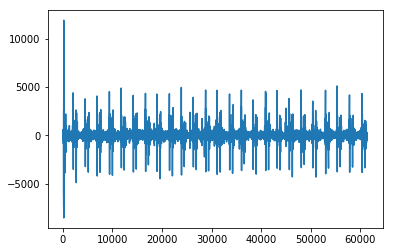

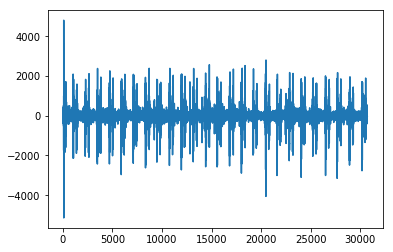

[array([-0.5849257 , -0.46036839,  0.08368894, ..., -0.29410936,
       -0.23180769, -0.19733666]), array([-0.62873722, -0.34635531,  0.03320568, ..., -0.47147747,
       -0.07555723, -0.08245513]), array([-0.72112731, -0.71220788, -0.70316314, ..., -0.74694572,
       -0.73851451, -0.72990237]), array([ 5.65634051e-01, -1.27872998e+00,  7.73939361e+00,  3.22291489e+00,
       -8.42543510e-01,  3.48017339e-01, -4.01221284e-01,  1.86896253e-01,
       -3.49242039e-01,  8.24989342e-03, -2.63897476e-01, -3.59920508e-02,
       -2.31966579e-01, -9.21226584e-02, -1.76353349e-01, -1.06285474e-01,
       -1.76995410e-01, -1.15417909e-01, -1.70358866e-01, -1.60622018e-01,
       -1.54037504e-01, -1.80040471e-01, -1.28238390e-01, -1.09294541e-01,
       -7.41929348e-02,  1.19469056e-01, -1.10821789e-01, -1.65213043e-01,
       -1.27209418e-01, -1.74605979e-01, -1.13522551e-01, -2.10253109e-01,
       -4.56869428e-02, -3.09693758e-02,  5.21397162e-03, -7.23479612e-02,
       -1.44352209e-01, -1.

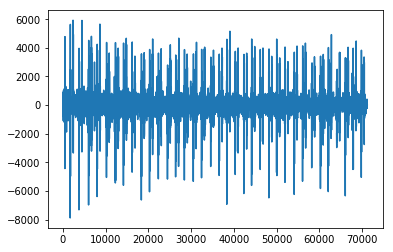

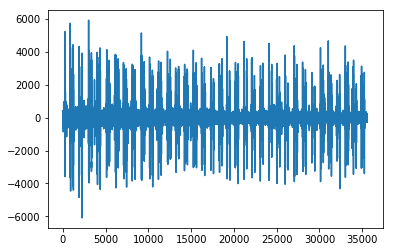

[array([-0.6985307 , -0.6620259 , -0.47632231, ..., -0.72786705,
       -0.67807817, -0.62155606]), array([-0.46485435, -0.63901651, -0.09701253, ..., -0.71905773,
       -0.57042238, -0.60078828]), array([-0.48632933, -0.48101237, -0.47528965, ..., -0.49997416,
       -0.49579725, -0.49125332]), array([ 0.10485621,  0.02374078,  0.16449263,  0.10960447, -0.43320144,
       -0.33254772,  2.76007047,  0.67547228, -0.68729888,  0.0276417 ,
       -0.59276455, -0.18890173, -0.47597293,  0.0262711 , -0.78969732,
        0.11090845, -0.45410226, -0.06656846, -0.70572133, -0.02507114,
        0.14996321,  0.10462609, -0.60999988,  0.11021012, -0.56131274,
        0.08384765, -0.98928698,  0.42741714, -1.64715591,  4.12695473,
        3.31893919, -1.40566821,  0.15023564, -0.75442288, -0.04572197,
       -0.58790757,  0.05722384, -0.62396141, -0.20984925, -0.69844156,
       -0.1401976 , -0.55728112, -0.35101479, -0.53546154, -0.19555494,
       -0.53482637, -0.0926571 , -0.30780717, -0.17407

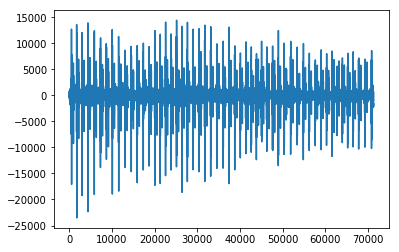

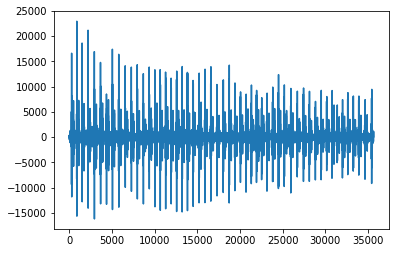

[array([-0.58902052, -0.66521239, -0.71110689, ..., -0.63735815,
       -0.64530437, -0.60738835]), array([-0.58447925, -0.58810802, -0.63418561, ..., -0.51559881,
       -0.58944322, -0.50950436]), array([-0.32739165, -0.2819605 , -0.23497371, ..., -0.45416501,
       -0.41351046, -0.3712475 ]), array([ 0.50878268, -0.36664289, -0.16260247, -0.54959714, -0.3433232 ,
       -0.77689813,  0.43156076,  1.76696643, -0.54494864, -0.4218039 ,
       -0.54981479, -0.61461814,  2.63492243,  0.39448701, -0.91218149,
       -0.18260629, -0.87997779, -0.26145486, -0.63863519, -0.29316036,
       -0.979564  ,  0.86001713,  2.13383572, -0.40678624, -0.56189514,
       -0.17740278, -1.09749322,  2.66705509,  1.30127098, -1.05798026,
       -0.09959826, -0.81289073, -0.31852705, -0.72517328,  0.03472391,
       -0.84837752,  0.00783292,  1.90533788,  0.08862098, -0.44849135,
       -0.34775689, -0.64411064, -0.41704262,  1.95045333, -0.211037  ,
       -0.76923285, -0.15379666, -0.72772585, -0.32587

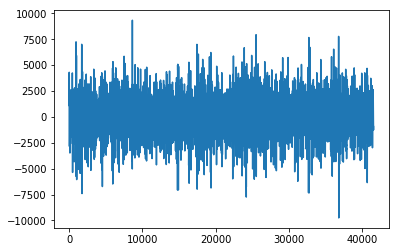

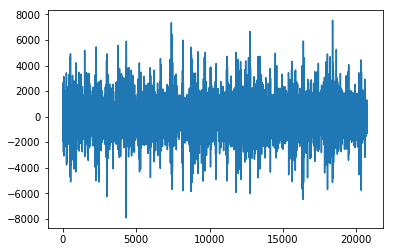

[array([-0.78902884, -0.16038995,  0.4138878 , ..., -0.97906001,
       -0.9447341 , -0.82486092]), array([-0.54939701,  0.04680965,  0.26467201, ..., -1.03483076,
       -0.85976056, -0.59242191]), array([-0.27422337, -0.23464507, -0.19196609, ..., -0.37480996,
       -0.34425253, -0.31074268]), array([-0.14936681, -0.51100599, -0.9301933 ,  0.40236279,  1.09214238,
        1.28634205,  0.28795048, -0.83651581, -0.56213309, -0.7595744 ,
       -0.95780848,  0.22503095,  0.94457298,  0.69612723,  1.53202924,
        1.15006347,  0.30445858,  0.3839578 ,  1.37344296,  0.78235627,
        2.2088131 ,  1.95173141,  1.7331513 ,  1.55733729, -0.0768715 ,
       -0.10674218, -0.76925928, -0.57299425, -1.32633733, -0.92931782,
       -1.19423626, -0.99771153, -0.9611971 , -0.96886891, -0.85674879,
       -0.62631587, -0.77853203, -0.62178352, -0.93996333, -0.0363181 ,
        1.81609646,  1.2843851 ,  0.72422634, -0.01868963,  0.11996687,
        0.06830826, -1.01844524, -0.99165769, -1.02747

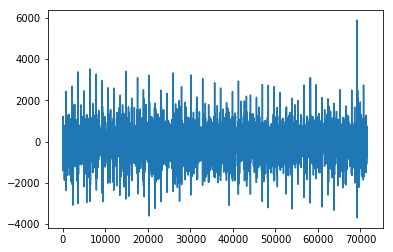

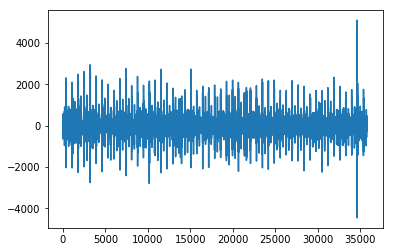

[array([-0.98646779, -0.91018305, -0.92586448, ..., -0.17121401,
       -0.73485741, -0.77351734]), array([-0.31995502,  0.18696542, -0.72612574, ...,  0.25037722,
       -0.7946973 , -0.7423294 ]), array([-0.29267423, -0.26894648, -0.24415863, ..., -0.35756908,
       -0.33697737, -0.31534862]), array([ 4.65357702,  0.24303076, -0.65534102, -0.4214582 , -0.77824316,
       -0.55880328, -0.0958836 , -1.06089768,  1.28803001,  3.22066751,
       -1.41300047,  0.5574756 , -0.61631033, -0.05886042, -0.45475721,
       -0.187234  , -0.36264114,  0.33320121, -0.68573191, -0.00501155,
       -0.83186303, -0.47228872, -0.85938803, -0.49373609, -0.66169641,
       -0.62403469, -0.6650874 ,  0.02110349, -0.5414407 ,  0.06912411,
       -0.70295725,  0.14885703, -0.31670052,  0.29120717,  0.16964682,
        3.17402724,  1.94681593, -0.23334624, -0.51233143, -0.67228394,
       -0.25513554, -0.39800591, -0.55832529, -0.35847286, -0.19251343,
        1.45017969,  0.08090673, -0.52390191, -0.51718

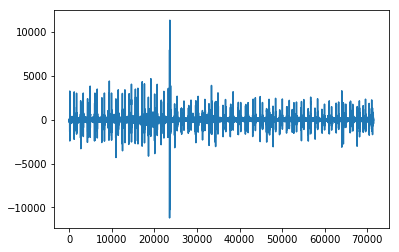

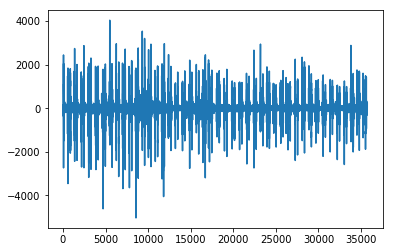

[array([-0.05037015, -0.28387609, -0.43482743, ..., -0.19706544,
       -0.32585275, -0.11503806]), array([-0.50237539, -0.21117178, -0.89885183, ..., -0.21315624,
       -0.62276689, -0.03969233]), array([-0.47961655, -0.50426259, -0.52920083, ..., -0.40788655,
       -0.43138438, -0.45530886]), array([-0.30542079, -0.56811404,  3.39748548, -0.16422435, -0.53638714,
       -0.39952159, -0.37059044, -0.26867359, -0.18564004, -0.20429032,
       -0.32455001, -0.26763621, -0.02950294, -0.4450109 ,  0.8675478 ,
        2.4218831 , -0.255733  ,  0.16445871, -0.18875645,  0.0650992 ,
       -0.4645947 ,  0.31950316,  3.82079216, -0.11047458, -0.52500555,
       -0.20452225, -0.39174735, -0.4467685 , -0.48889169, -0.43582411,
       -0.45674823, -0.47068836, -0.40693711, -0.52484511,  1.16910914,
        1.18597969, -0.58601253,  0.08105402, -0.8470518 ,  0.29248461,
       -1.35349771,  2.38913877,  2.00926751, -0.98819368, -0.20687023,
       -0.54527305, -0.32851047, -0.56801167, -0.39945

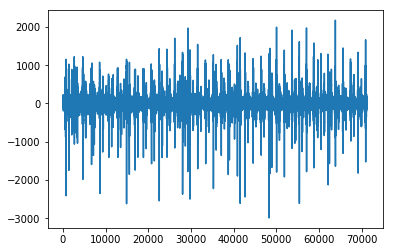

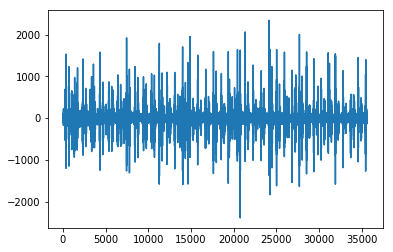

[array([-0.69347505, -0.72013359, -0.69574483, ..., -0.51286412,
       -0.57732987, -0.46124126]), array([-0.62806469, -0.35164842, -0.66269838, ..., -0.47208744,
       -0.5620859 , -0.30096793]), array([-0.58960361, -0.56580508, -0.5415063 , ..., -0.65773342,
       -0.63559326, -0.612875  ]), array([ 0.02593131, -0.60436696, -0.04071823, -0.7439166 , -0.56201349,
        0.05997645,  0.5100169 , -0.7649864 ,  0.62964838,  1.14410904,
       -0.24284374, -0.19362331, -0.32131603, -0.20655933, -0.56743797,
        0.10262633,  0.29784397, -0.12047076,  0.0602589 , -0.39125915,
       -0.28785328, -0.13637787,  0.47567009, -0.57131312, -0.32699501,
       -0.49277237,  0.59184442, -0.46700849,  0.18481344,  0.12250776,
       -0.60321472, -0.50726464, -0.2122325 ,  1.43527078, -1.1998344 ,
        1.3042833 ,  1.10828506, -0.44324437,  0.41309719, -0.59089175,
       -0.27436423, -0.47975582,  5.66030698,  1.06921493,  0.18006169,
       -0.94305653,  0.57038158, -0.83076741, -0.47705

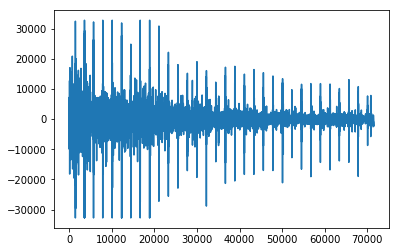

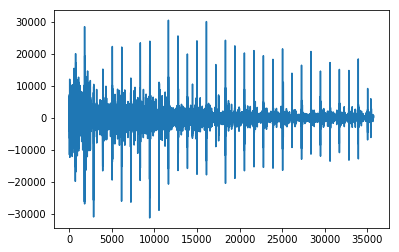

[array([-1.03762519, -0.32947557,  1.37797126, ..., -0.90355518,
       -0.99898958, -1.04364755]), array([-0.6286352 ,  0.66731187,  2.65525462, ..., -0.69469995,
       -0.71989216, -0.84953964]), array([-0.28642078, -0.30267616, -0.31894306, ..., -0.23814997,
       -0.2541161 , -0.27022005]), array([-0.23269543,  0.26232219, -0.37494347, -0.4505534 , -0.48559894,
       -0.54516641, -0.44094125, -0.53553041, -0.29551634,  0.39300448,
        0.064198  , -0.16249377, -0.02636112, -0.23727134,  0.11287951,
       -0.1883169 , -0.46734117, -0.57723141,  3.76536021,  1.60849334,
        0.35625564,  1.31857089,  0.21133765,  0.96213892, -0.00622298,
        0.8100897 ,  0.73129448,  0.73422627, -0.46877997, -0.26162302,
       -0.52967704, -0.27723554,  0.29951693, -0.55180508, -0.13933097,
        0.27095336, -0.05076037, -0.44117041, -0.39751057, -0.08103781,
       -0.40355274, -0.5259152 , -0.3520188 , -0.59920327,  0.75144696,
        5.92156997,  0.02470016,  0.58035204,  0.24915

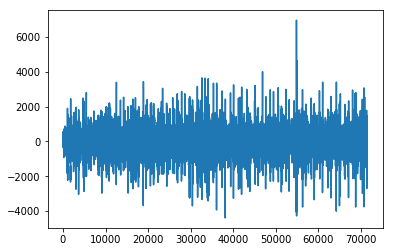

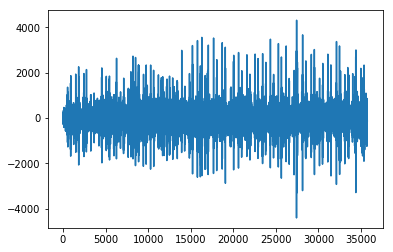

[array([-0.80098636, -1.38683727, -1.24525335, ..., -0.22944212,
       -0.00730807,  0.1338928 ]), array([-0.7385084 , -1.01784056, -1.06261613, ..., -0.52173195,
        0.14004886,  0.30638426]), array([-0.34246787, -0.33559927, -0.3283283 , ..., -0.36076918,
       -0.35504182, -0.34894506]), array([ 0.23736875, -0.11732851, -0.38455102, -0.14305367, -0.45376692,
       -0.31994701, -0.29709151, -0.20629489, -0.43374408, -0.34770259,
       -0.1801606 , -0.23679018, -0.34418557, -0.11434618, -0.38026845,
       -0.3474256 , -0.23827874, -0.35335446,  0.26149818, -0.37890535,
        0.47752466, -0.15381381,  1.50438055,  1.6306895 , -0.59969148,
        0.22356555, -0.2798136 , -0.11972747, -0.21313028,  0.27873017,
        0.05873581,  0.90042541,  1.03854178,  0.80583808,  0.75245904,
        0.31671683,  0.05886777,  0.28387177, -0.41976855, -0.02176757,
       -0.46503769, -0.0670351 , -0.02558668,  0.20196328, -0.40689377,
        0.30967736,  1.52018091,  0.05768898, -0.58702

In [14]:
# Heart sound segmentation functions

def normalise(data):
    """
    Subtract mean and divide by standard deviation of
    data
    
    Input:
            data            :  numpy original signal
    
    Output:
            normalise_data  :  original minus mean and
                               devide by standard deviation
    """
    
    mean = np.mean(data)
    std = np.std(data)
    
    normalise_data = (data - mean) / std
    
    return normalise_data


def get_homomorphic_envelogram(data, fs, lpf_freq=8):
    """
    Homomorphic envelogram derived by exponentiating 
    the low-pass filtered naturallogarithm of a signal
    
    Inputs:
            data      :   numpy data
            fs        :   sample rate of data
            lpf_freq  :   frequency cut-off (8Hz by default)
            
    Output:
            ho_env :   homorphic envelope of
                                data (not normalised)
    """
    
    b, a = butter(1, 2 * lpf_freq / fs, 'low')
    ho_env = np.exp(filtfilt(b, a, np.log(np.abs(hilbert(data)))))
    return ho_env


def get_Hilbert_envelope(data):
    """
    Hilbert envelope is calculated from the absolute value
    of the Hilbert transform
    
    Input:
            data    :   numpy data to extract
            
    Output:
            hilbert_env  :   Hilbert envelope of data
                             (not normalised)
    """
    hilbert_env = np.abs(hilbert(data))
    return hilbert_env


def get_PSD_feature(data, fs, low, high):
    """
    PSD-based feature extraction for heart sound segmentation
    
    Inputs:
            data    :   numpy data to extract
            fs      :   sample rate of data
            low     :   lower-bound frequency to analyse
            high    :   upper-bound frequency to analyse
    
    Output:
            psd     :   array of maximum PSD values between
                        max and min limits, resampled to
                        same size as data
    """
    
    # find spectrogram of data
    f, t, Sxx = spectrogram(data, fs, nperseg=int(fs*0.05), \
                                   noverlap=int(fs*0.025))
    low_pos = np.argmin(np.abs(f-low))
    high_pos = np.argmin(np.abs(f-high))
    
    # find mean PSD over frequency range of interest
    psd = np.mean(Sxx[:,low_pos:high_pos+1], axis=1)
    return psd


def get_PCG_features(data, fs):
    """
    Get features used in Springer segmentation:
            - Homomorphic envelope
            - Hilbert envelope
            - Wavelet-based feature
            - PSD-based feature
    
    Inputs:
            data     :    numpy signal to extract features
            fs       :    sample rate of data
            
    Outputs:
            PCG_features  :   array of derived features
            features_fs   :   sample rate of derived features
    """
    
    # 25-400Hz 4th order Butterworth bandpass
    data = butter_bandpass_filter(data, 25, 400, rate, 4)
    # Remove spikes
    data = schmidt_remove_spikes(data, fs)
    # default feature_fs
    features_fs = 50
    
    # Find, downsample and normalise Homomorphic envelogram
    ho_env = get_homomorphic_envelogram(data, fs)
    _, ho_env = resample(ho_env, fs, features_fs)
    ho_env = normalise(ho_env)
    
    # Find, downsample and normalise Hilbert envelope
    hilbert_env = get_Hilbert_envelope(data)
    _, hilbert_env = resample(hilbert_env, fs, features_fs)
    hilbert_env = normalise(hilbert_env)
    
    # Find, downsample and normalise Power spectral density feature
    psd = get_PSD_feature(data, fs, 40, 60)
    _, psd = resample(psd, psd.shape[0], ho_env.shape[0])
    psd = normalise(psd)
    
    # Wavelet features
    cA, cD = pywt.dwt(data, 'db7')
    wavelet_ftr = np.abs(cD)
    wavelet_ftr = wavelet_ftr[:ho_env.shape[0]]
    _, wavelet_ftr = resample(wavelet_ftr, fs, features_fs)
    wavelet_ftr = normalise(wavelet_ftr)
    
    PCG_features = [ho_env, hilbert_env, psd, wavelet_ftr]
    return PCG_features, features_fs


# test
k = 0
for file in glob.glob('./abnormal/*.wav'):
    print('Processing ' + file + '...')
    (rate, data) = read(file)
    show(data)
    (data, rate) = pre_process(data, rate)
    show(data)
    features, fs = get_PCG_features(data, rate)
    print(features)
    k=k+1
    if (k > 10):
        break